# Simple image classifier experiment

In [14]:
# Any edits to libraries are reloaded automatically 
# Images are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
from fastai.vision import *
from fastai.metrics import error_rate

#### Let's use oxford univ pet dataset
http://www.robots.ox.ac.uk/~vgg/data/pets/

In [29]:
path = untar_data(URLs.PETS); path

PosixPath('/home/nicoco/.fastai/data/oxford-iiit-pet')

In [30]:
path.ls()

[PosixPath('/home/nicoco/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/nicoco/.fastai/data/oxford-iiit-pet/images')]

In [31]:
path_anno = path/'annotations'
path_img = path/'images' 

In [65]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/nicoco/.fastai/data/oxford-iiit-pet/images/saint_bernard_123.jpg'),
 PosixPath('/home/nicoco/.fastai/data/oxford-iiit-pet/images/Russian_Blue_203.jpg'),
 PosixPath('/home/nicoco/.fastai/data/oxford-iiit-pet/images/Bombay_160.jpg'),
 PosixPath('/home/nicoco/.fastai/data/oxford-iiit-pet/images/pug_148.jpg'),
 PosixPath('/home/nicoco/.fastai/data/oxford-iiit-pet/images/Bengal_112.jpg')]

In [66]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [42]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=64
                                  ).normalize(imagenet_stats)

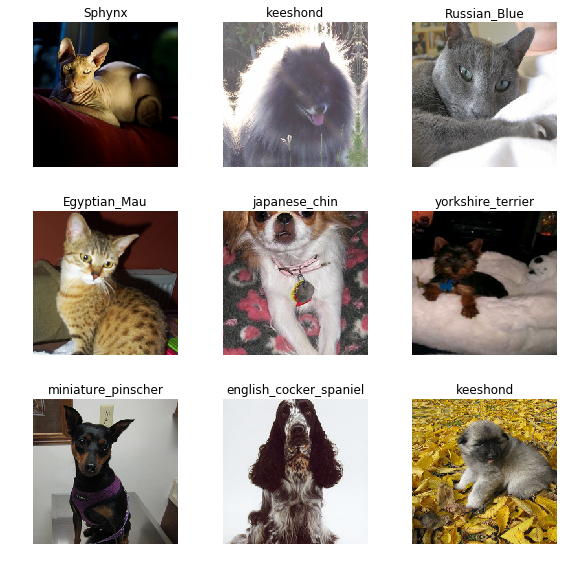

In [62]:
data.show_batch(rows=3, figsize=(8,8))

In [63]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [64]:
len(data.classes), data.c

(37, 37)

# TRAINING convolutional neural network

In [67]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/nicoco/.torch/models/resnet34-333f7ec4.pth
87306240it [00:07, 11318289.00it/s]


In [68]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [69]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.386672,0.342013,0.104195
2,0.563380,0.236409,0.078484
3,0.354614,0.197895,0.062923
4,0.261984,0.189232,0.060217


In [70]:
learn.save('res34_first')

# Results

In [71]:
interp = ClassificationInterpretation.from_learner(learn)

In [73]:
losses,idxs = interp.top_losses()

In [74]:
len(data.valid_ds)==len(losses)==len(idxs)

True

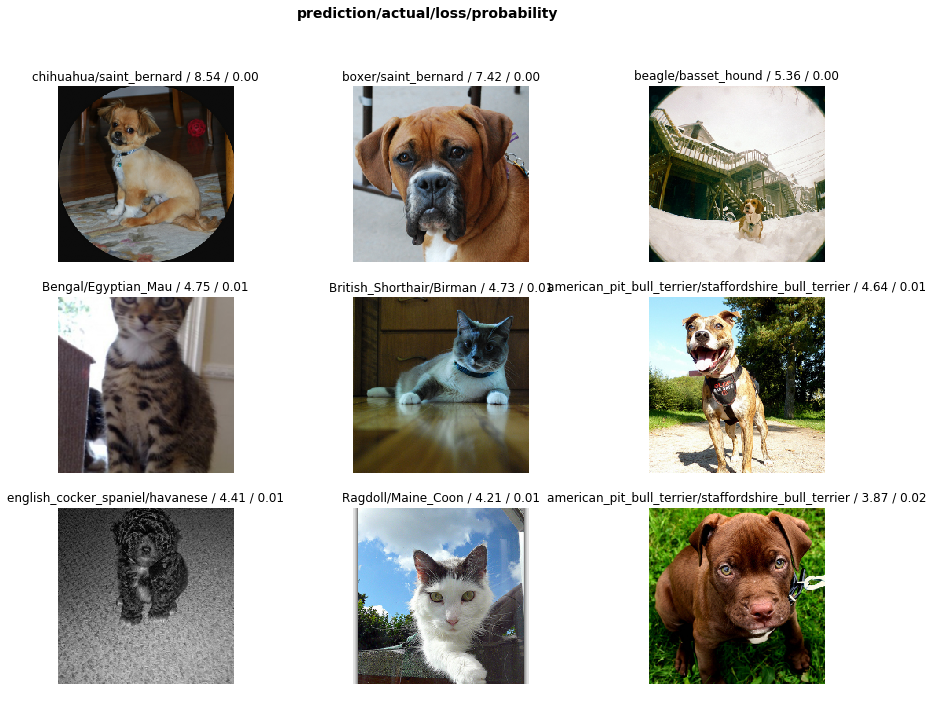

In [75]:
interp.plot_top_losses(9, figsize=(15,11))

In [76]:
doc(interp.plot_top_losses)

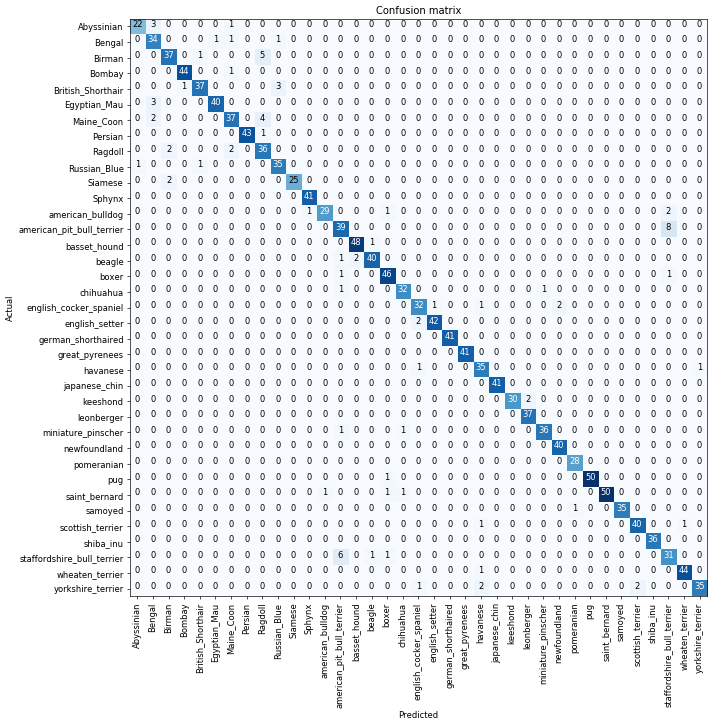

In [77]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [78]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Birman', 'Ragdoll', 5),
 ('Maine_Coon', 'Ragdoll', 4),
 ('Abyssinian', 'Bengal', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Egyptian_Mau', 'Bengal', 3)]

# Unfreezing

In [79]:
learn.unfreeze()

In [80]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.566187,0.316980,0.110284


In [81]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.420543,0.295082,0.089310


In [83]:
learn.load('res34_first');

In [84]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


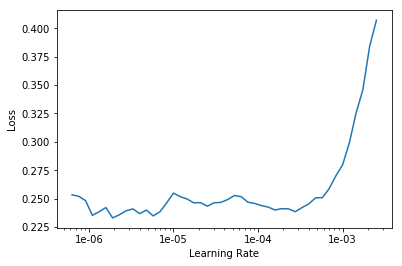

In [85]:
learn.recorder.plot()

In [93]:
learn.load('res34_first');

In [94]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [95]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.235805,0.179796,0.058863
2,0.221887,0.179103,0.054804


# LULZ

In [100]:
img = open_image('/home/nicoco/.fastai/data/testPics/beethover_baby.jpg')

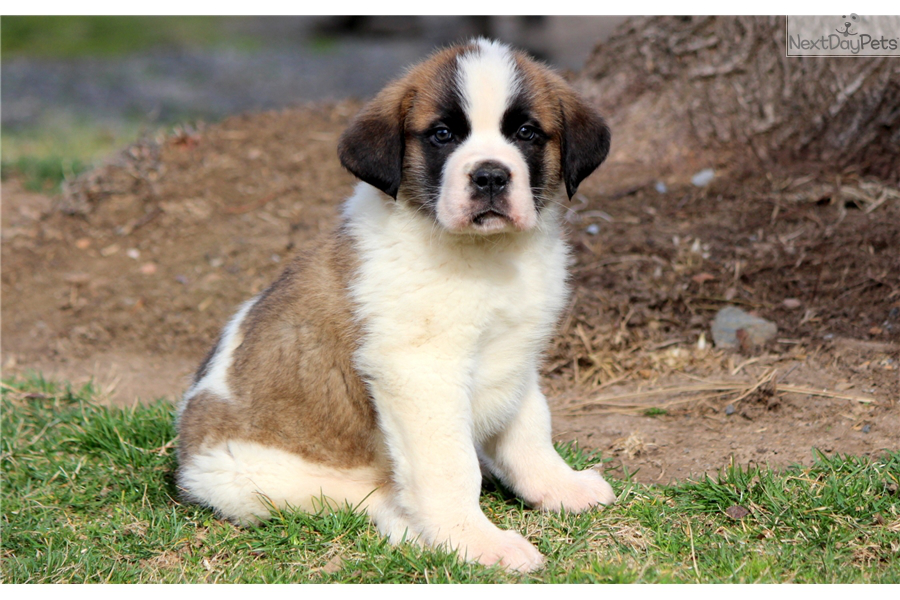

In [101]:
img

In [102]:
learn.predict(img)

(Category saint_bernard,
 tensor(30),
 tensor([5.2590e-07, 7.7102e-07, 1.9547e-06, 4.5248e-07, 2.5059e-07, 2.8596e-07,
         2.5067e-06, 1.4913e-06, 5.5252e-06, 4.5045e-07, 3.0905e-06, 9.0339e-07,
         2.8656e-04, 1.9182e-06, 2.7131e-06, 1.2393e-05, 1.0155e-04, 3.5334e-07,
         3.7799e-07, 3.5382e-06, 2.4194e-06, 2.8986e-05, 5.1942e-06, 7.2222e-05,
         3.9787e-07, 2.8789e-04, 1.3840e-07, 8.2175e-06, 7.1028e-07, 9.3472e-06,
         9.9915e-01, 1.1954e-06, 1.6014e-07, 2.9976e-06, 5.6579e-06, 3.3977e-07,
         2.7159e-07]))